# 1. Imports

In [1]:
import os
import glob
from datetime import timedelta, date

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline
import itertools
import powerlaw

# 2. Functions

## 2.1 Define epoch function

In [2]:
def datime2epoch(dt):
    """
    Thi is an example script.

    It seems that it has to have THIS docstring with a summary line, a blank line
    and sume more text like here. Wow.
    """
    # cast dt into string in case it isn't 
    dt = str(dt)
    if dt != 'summary':
        if str(dt) != 'nan':
            if '_' in dt:
                YYYY, mm, dd = dt.split('_')
            else:
                YYYY = dt[0:4]
                mm = dt[4:6]
                dd = dt[6:8]
            return (
                date(
                    int(YYYY),
                    int(mm),
                    int(dd)
                ) - date(1970 ,1, 1)
            ).total_seconds()
        else:
            return -1
    else:
        return -1

# 3. Get AS node degree of connected networks

## 3.1 Compute AS node degree 

In [3]:
def get_members_neighbors(bgp_table_dump_df, ixp_asn):
    """
    Thi is an example script.

    It seems that it has to have THIS docstring with a summary line, a blank line
    and sume more text like here. Wow.
    """
    # create dict of IXP members
    members_degree_dict = {}
    # Loop
    for as_path_str in bgp_table_dump_df.drop_duplicates(
        'as-path')['as-path'].values:
        as_path_list = as_path_str.split(',')
        # if AS-PATH contains more than one AS
        # If not, the IXP member is directly annoucing 
        # its routes to the monitor
        if len(as_path_list) > 1:
            # Removes path through HE (AS6939 from the path)
            if int(as_path_list[0]) != 6939 and int(as_path_list[1]) != 6939:
            # Checks if the route server is the once announcing the path
            # If so, remove IXP ASN from path
            # If not, it is direct member
                add_flag = False
                if (ixp_asn is None) and len(as_path_list) >= 2:
                    member_as = as_path_list[0]
                    neighbor_as = as_path_list[1]
                    add_flag = True
                elif len(as_path_list) >= 3:
                    member_as = as_path_list[1]
                    neighbor_as = as_path_list[2]
                    add_flag = True
                else:
                    pass
                if add_flag:
                    if member_as not in members_degree_dict.keys():
                        members_degree_dict[member_as] = set()
                    members_degree_dict[member_as].add(neighbor_as)
    return members_degree_dict

In [4]:
ixp_under_analysis_list = [
    # Frankfurt (DE-CIX)
    'fra',
    # Paris (Frace-IX)
    'cdg',
    # Bangkok (BNKIX)
    'bkk',
    # Johanesburg (JINX)
    'jnb',
    # IX.br Sao Paulo
    'saopaulo',
    # CABASE-BUE
    'eze',
    # PIT Chile
    'scl'
]

In [5]:
ixp_asn_dict = {
    'eze': 11058,
    'scl': 61522,
    # We do not care about this now
    'fra': None,
    # We do not care about this now
    'cdg': None,
    # We do not care about this now
    'bkk': None,
    # We do not care about this now
    'jnb': None,
    # We do not care about this now
    'saopaulo': None,
}

In [6]:
PATH_TO_BGP_DUMPS = '../../data/processed/ribs/v4'

**MAIN BLOCK OF THIS NOTEBOOK**

In [7]:
ixp_members_degree_dict = {}
for ixp in ixp_under_analysis_list:
    ixp_members_degree_dict[ixp] = {}
    # get all BGP table dumps
    ixp_bgp_table_dump_files_a = np.array(glob.glob(PATH_TO_BGP_DUMPS + '/' + ixp + '/*'))
    # sort BGP table dumps by ASCENDING DATE
    ixp_bgp_table_dump_files_a = np.sort(ixp_bgp_table_dump_files_a)
    # Just look at the latest month
    bgp_table_dump_df = pd.read_csv(
        ixp_bgp_table_dump_files_a[-1],
        header='infer',
        sep=','
    )
    # Remove NaN path if exists
    bgp_table_dump_df = bgp_table_dump_df.loc[
        bgp_table_dump_df['as-path'].notnull()
    ]
    # find visible ASes from BGP table dump
    members_neighbors_dict = get_members_neighbors(bgp_table_dump_df, ixp_asn_dict[ixp])
    for asn in members_neighbors_dict.keys():
        ixp_members_degree_dict[ixp][asn] = len(list(members_neighbors_dict[asn]))

## 3.2 Output results

### 3.2.1 TOP3: AS node degree by IXP

In [8]:
for ixp in ixp_under_analysis_list:
    vals = np.array(list(ixp_members_degree_dict[ixp].values()))
    vals = np.sort(vals)
    print(ixp[:3], vals[-3:])

fra [ 823 1487 1825]
cdg [641 728 815]
bkk [22 30 49]
jnb [ 59 113 161]
sao [148 157 484]
eze [49 81 86]
scl [18 21 48]


### 3.2.2 AS node degree percentile by IXP

In [9]:
output_list = []
for ixp in ixp_under_analysis_list:
    vals = np.array(list(ixp_members_degree_dict[ixp].values()))
    q_a = np.percentile(vals, np.arange(0, 101, 25), interpolation='lower')
    output_list.append(np.hstack(np.array(([ixp[:3],], q_a))))

pd.DataFrame(
    output_list,
    columns=['ixp','min','Q1',
             'Q2','Q3','max']
)

,ixp,min,Q1,Q2,Q3,max
0,fra,1,2,9,34,1825
1,cdg,1,1,3,10,815
2,bkk,1,1,4,9,49
3,jnb,1,2,4,15,161
4,sao,1,1,3,8,484
5,eze,1,1,2,9,86
6,scl,1,1,1,5,48


### 3.2.3 fit power-law distribution to AS node degree

In [10]:
for ixp in ixp_under_analysis_list:
    vals = np.array(list(ixp_members_degree_dict[ixp].values()))
    results = powerlaw.Fit(vals)
    R, p = results.distribution_compare('power_law', 'lognormal_positive')
    print("%s\t%.2f\t%.2f\t%.2f" % (ixp[:3], results.power_law.alpha, results.power_law.xmin, p))

Calculating best minimal value for power law fit
/home/carisimo/latam-ixp-obs/latam-ixp-obs/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


fra	2.17	50.00	0.79
cdg	1.83	13.00	0.83
bkk	1.62	1.00	0.61
jnb	2.11	9.00	0.71
sao	2.35	16.00	0.77
eze	1.77	1.00	0.13
scl	1.98	1.00	0.13


/home/carisimo/latam-ixp-obs/latam-ixp-obs/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


## 3.3 Plot results

In [11]:
label_dict = {
    'scl': 'PIT Chile-SCL',
    'eze': 'CABASE-BUE',
    'asu': 'IX.py',
    'saopaulo': 'IX.br',
    'fra': 'DE-CIX-fra',
    'cdg': 'France-IX-Paris',
    'jnb': 'JINX',
    'bkk': 'BKNIX',
}

In [12]:
def gen_cdf(ax, x, label_str, mkr):
    """
    Thi is an example script.

    It seems that it has to have THIS docstring with a summary line, a blank line
    and sume more text like here. Wow.
    """
    # Overlay a reversed cumulative histogram.
    bins = np.logspace(np.log10(x.min()), np.log10(x.max()), np.ceil(np.sqrt(x.size / 2)) + 0)
    widths = (bins[1:] - bins[:-1])
    # Calculate histogram
    hist = np.histogram(x, bins=bins)
    # normalize by bin width
    hist_norm = hist[0] / widths
    # plot it!
    ax.plot(
        (bins[1:] + bins[:-1]) / 2.0,
        hist_norm,
        marker = mkr,
        label=label_str,
        alpha=0.5,
        linewidth=3
    )


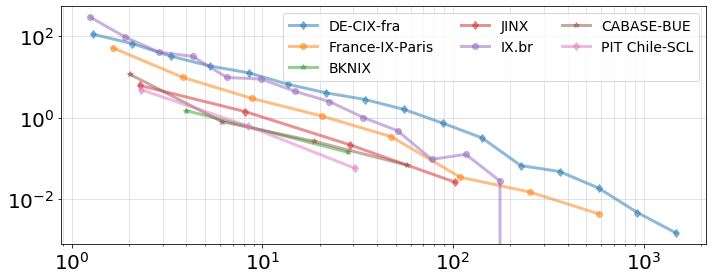

In [13]:
marker_iter = itertools.cycle(('d', 'o', '*')) 
fig, ax1 = pl.subplots(1, figsize=(10, 4))
ax1.yaxis.grid(True, linestyle='-', color='#bababa', which='both', alpha=0.5)
ax1.xaxis.grid(True, linestyle='-', color='#bababa', which='both', alpha=0.5)
# plot frac for each AS
for ixp in ixp_under_analysis_list:
    gen_cdf(ax1, np.array(list(ixp_members_degree_dict[ixp].values())),
            label_dict[ixp], next(marker_iter))

ax1.tick_params(labelsize=20)


ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.legend(loc='upper right', ncol=3, frameon=True, fontsize=14)
fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig('../../figures/5_as_node_degree.pdf')